### Data reduction for paleomagnetic data aboard the JOIDES Resolution

This notebook is for people wanting to download and manipulate data from an IODP Expedition using data in the LIMS Online Repository.  The basic procedure is as follows.  This notebook will guide you through the process step-by-step.   

- Import the required python packages and set up the desired directory structure for each HOLE. 
- Download the Section Summary table using the "download tabular data" optiopn in LORE and put the .csv file in the HOLE working directory
- Download the sample table for any discrete samples taken and put them in the HOLE working directory
- Download the SRM data for the hole and put them in the SRM working directory in the HOLE working directory 
- Download the SRM discrete measurement data for the hole and put them in the SRM_discrete sample working directory.
- Download the JR6 data and put them in the JR6 working directory
- Download the KLY4S data and put them in the KLY4S working directory.
- If you want to edit the archive half data for coring or lithologic disturbances:
- Download the core disturbance info from Desklogic
    - go to the Desklogic computer station and open DeskLogic (little yellow square)
    - select the 'macroscopic' template
    - select sample: hole, Archive, section half
    - download
    - export: include classification, Data and save on the Desktop
    - if the network drives are not available, right click on the double square icon on bar
    - switch the login profile to scientist and login with OES credentials (user name/email password)
    - choose scientist and map the drives.  they should be now available to windows explorer
    - copy to your HOLE working directory.  
- If you want to use Xray information to edit your archive half data:  fill in  the XRAY disturbance summary file and put it into the HOLE working directory

To start processing data from a single HOLE:

- Duplicate this notebook with the HOLE name (e.g., U1534A) by first making a copy, then renaming it under the 'File' menu.  Follow the instructions below. 

For HELP:   
    - for help on options in any python function, you can type:
    help(MODULE.FUNCTION)  in the cell below.    For example click on the cell below for information on how to use convert.iodp_samples_csv.  This works for any python function.  
    - email ltauxe@ucsd.edu.  Incluede a description of your problem, a screen shot of the error if appropriate and an example data file that is causing the difficulty (be mindful of embargo issues).  



## Table of Contents

- [Preliminaries](#preliminaries) : import required packages and set up directory structure
- [Make sample tables](#sample) : parse downloaded sample table to standard format
- [Archive measurements](#archives) : parse downloaded srm archive measurements and perform editing functions
- [Icefield orientation adjustments](#icefield) : attempt core orientation
- [Discrete sample measurements](#discretes) : parse downloaded discrete sample data
- [Downhole plots](#plots) : make downhole plots of remanence
- [Anisotropy of magnetic susceptibility](#aniso) : plots of AMS
- [Prepare files for uploading to MagIC](#upload) : you can upload data to the MagIC database as a private contribution.  Then when you have published your data, you can activate your contribution with the DOI of your publication.  

<a id='preliminaries'></a>


## Preliminaries

- In the cell below, edit the HOLE name  and set the HOLE latitude and longitude  where HOLE stands for the hole name.  The cell below will do this for you. 

- To set up the file structure the first time for every hole, set mkdir to True but only execute it once for each HOLE! After you have run this, set mkdir to False

- Every time you open this notebook, you must click on the cell below and then click 'Run' in the menu above to execute it. 

In [23]:
# import a bunch of packages for use in the notebook
import pmagpy.pmag as pmag # a bunch of PmagPy modules
import pmagpy.pmagplotlib as pmagplotlib
import pmagpy.ipmag as ipmag
import pmagpy.contribution_builder as cb
from pmagpy import convert_2_magic as convert # conversion scripts for many lab formats
from pmagpy import  iodp_funcs as iodp_funcs # functions for dealing with LIMS data
import matplotlib.pyplot as plt # our plotting buddy
import numpy as np # the fabulous NumPy package
import pandas as pd # and of course Pandas
%matplotlib inline 
from importlib import reload
import warnings 
warnings.filterwarnings("ignore")
meas_files,spec_files,samp_files,site_files=[],[],[],[] # holders for magic file names
import os



# Modify these for your expedition
exp_name,exp_description='IODP Expedition 999','IODP Test Site'

# Edit these for each hole.  
hole='U999A'
hole_lat,hole_lon=0+0/60,0+0/60 # edit these for the current hole - get it from Hole summary on downloaded as LORE
gad_inc=pmag.pinc(hole_lat)
dscr_file=""

demag_step=0.010 # choose the demagnetization step (in tesla) for downhole plots 


# set up the directory structure for this hole



jr6_dir=hole+'/JR6_data'
kly4s_dir=hole+'/KLY4S_data'
srm_archive_dir=hole+'/SRM_archive_data'
srm_discrete_dir=hole+'/SRM_discrete_data'
magic_dir=hole+'/'+hole+'_MagIC'

# only run this once.  To create the file structure, change the "False" below to "True" and execute this cell

# After you have run this cell once, please change the "True" back to "False" 
# or you will get an error because the directories already exist  

mkdir=False 
if mkdir:
    os.mkdir(hole)
    os.mkdir(jr6_dir)
    os.mkdir(kly4s_dir)
    os.mkdir(srm_archive_dir)
    os.mkdir(srm_discrete_dir)
    os.mkdir(magic_dir)
    os.mkdir('Figures')

#After mkdir has been run ONCE, 
# set mkdir to False, download the summary file and put the name in here, then 
# re-run this cell.  Run it everytime you open this notebook. 
section_summary_file="Section Summary_17_5_2019.csv" # set this to the downloaded summary file (e.g., Section Summary_15_5_2019.csv)
if section_summary_file:
    summary_file=hole+'/'+section_summary_file # Edit this


<a id='sample'></a>



### Make the sample tables

- Download the Sample Report and Section Summary tables (when available) for the HOLE from the LIMS online repository at http://web.ship.iodp.tamu.edu/LORE/ and save them as csv files.    
- Put the two .csv files in the HOLE directory created above.   
- Edit the name of the sample .csv  file and the 'secondary depth' column that you selected when downloading (the default is CSF-B as below) in the cell below. 
- Execute the cell to  populate the MagIC meta-data tables.  The depth information ends up in the lims_sites.txt table in the HOLE_MagIC directory, for example and gets used to create downhole plots.

Run the following cell to create the samples, sites, and locations tables for the hole.  

In [7]:
# Fill in the name of your sample file (e.g., samp_file='samples_5_4_2019.csv' )
# Make sure the sample file is in your HOLE directory. 
# Note:  this program will not run if the file is in use
samp_file="samples_17_5_2019.csv"
if samp_file:
    
    comp_depth_key='Top depth CSF-B (m)'
# do the heavy lifting: 
    convert.iodp_samples_csv(samp_file,input_dir_path=hole,spec_file='lims_specimens.txt',\
                         samp_file='lims_samples.txt',site_file='lims_sites.txt',\
                         dir_path=magic_dir,comp_depth_key=comp_depth_key,\
                exp_name=exp_name,exp_desc=exp_description,lat=hole_lat,\
                lon=hole_lon)
# this collects the file names that were created so they can be combined with others, e.g., those
# from the archive half measurements which are not in the sample table. 
    if 'lims_specimens.txt' not in spec_files:spec_files.append('lims_specimens.txt')
    if 'lims_samples.txt' not in samp_files:samp_files.append('lims_samples.txt')
    if 'lims_sites.txt' not in site_files:site_files.append('lims_sites.txt')
# do it again to make copies for use with demag_gui
    convert.iodp_samples_csv(samp_file,input_dir_path=hole,\
                         dir_path=magic_dir,comp_depth_key=comp_depth_key,\
                exp_name=exp_name,exp_desc=exp_description,lat=hole_lat,\
                lon=hole_lon)


U999A
11  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/lims_specimens.txt
11  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/lims_samples.txt
11  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/lims_sites.txt
1  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/locations.txt
U999A
11  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/specimens.txt
11  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/samples.txt
11  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/sites.txt
1  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/locations.txt


<a id='archives'></a>


### Convert the SRM archive half data for the Hole

- download data for a single hole from LORE as a csv file.
- put the file into the HOLE/SRM_archive_data directory in the HOLE directory
- edit the file name and the composite depth column header (comp_depth_key) if desired.
- if you have been busy measuring archives, writing the measurement files can take awhile so be patient.  


In [8]:
 
# Fill in the name of your srm archive half measruement file (e.g., samp_file='samples_5_4_2019.csv' )
# Make sure the sample file is in your HOLE directory. 
# Note:  this program will not run if the file is in use

srm_file="srmsection_17_5_2019.csv"   
if srm_file:
 
    comp_depth_key='Depth CSF-B (m)'

    convert.iodp_srm_lore(srm_file,meas_file='srm_arch_measurements.txt', comp_depth_key=comp_depth_key,\
                  dir_path=magic_dir,input_dir_path=srm_archive_dir,lat=hole_lat,lon=hole_lon)
    if 'srm_arch_measurements.txt' not in meas_files:meas_files.append('srm_arch_measurements.txt')
    if 'srm_arch_specimens.txt' not in spec_files:spec_files.append('srm_arch_specimens.txt')
    if 'srm_arch_samples.txt' not in samp_files:samp_files.append('srm_arch_samples.txt')
    if 'srm_arch_sites.txt' not in site_files:site_files.append('srm_arch_sites.txt')


2804  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/srm_arch_specimens.txt
2804  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/srm_arch_samples.txt
2804  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/srm_arch_sites.txt
791  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/srm_arch_measurements.txt


Editing of SRM archive data.


- filter for desired demag step (set in the preliminaries cell). 
- remove data from within 80 cm of core tops and 10 cm from section ends.
- if desired: (set nodist=True), remove from "disturbed" intervals labled "high" from DescLogic. 
    - go to DescLogic and export the list of disturbances for the hole.
    - put this in HOLE_disturbances.xlsx in the hole directory. note that HOLE is your hole name, set in the "preliminaries" cell. 
- remove data from disturbed intervals based on the Xrays. You have to create the Xray data file yourself. There is a template for this that must be followed.  
- adjust the data to average normal dec=90


In [12]:
# to execute this cell, set False to True. turn it back to False so you don't rerun this by accident. 
remove_ends=True
remove_desclogic_disturbance=False # no DescLogic examples for fake data!
remove_xray_disturbance=False # no Xray disturbance file for fake data!  

if True:
    arch_demag_step=iodp_funcs.demag_step(magic_dir,hole,demag_step)    # pick the demag step
    if remove_ends:
        noends=iodp_funcs.remove_ends(arch_demag_step,hole) # remove the ends
    else:
        noends=arch_demag_step
    if remove_desclogic_disturbance:
        nodist=iodp_funcs.remove_disturbance(noends,hole) # remove coring disturbances
    else: 
        nodist=noends
    if remove_xray_disturbance: 
        no_xray_df=iodp_funcs.no_xray_disturbance(nodist,hole)
    else:
        no_xray_df=nodist
    adj_dec_df,core_dec_adj=iodp_funcs.adj_dec(no_xray_df,hole)

Here's your demagnetization step DataFrame
Here's your no end DataFrame
Adjusted Declination DataFrame returned


<a id='discretes'></a>

### Convert SRM discrete sample data to MagIC:
- download data for a single hole from LORE as a csv file.
    - for OFFLINE treatments (ARM,IRM, DTECH AF, thermal), download both the 
      "standard" and the extended file names
- put the file into the HOLE/SRM_discrete_data directory in the HOLE directory
- for "regular" SRM files (no offline treaments) edit the file name and execute the cell below:

In [13]:
srm_discrete_file= 'srmdiscrete_17_5_2019.csv' # SRM discrete measurements

if srm_discrete_file:

    convert.iodp_dscr_lore(srm_discrete_file,meas_file='srm_dscr_measurements.txt', \
                  dir_path=magic_dir,input_dir_path=srm_discrete_dir,spec_file='lims_specimens.txt')
    if 'srm_dscr_measurements.txt' not in meas_files:meas_files.append('srm_dscr_measurements.txt')
    dscr_file='srm_dscr_measurements.txt'

 -W-  999-U999A-1H-2-W-140.0  not found in specimens table 
check your sample name or add to specimens table by hand

34  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/srm_dscr_measurements.txt


- for OFFLINE treatments: specify the extended discrete srm file name.

In [6]:
dscr_ex_file='' # SRM discrete extended file
srm_discrete_file='' # SRM discrete measurements
if dscr_ex_file and srm_discrete_file:


    convert.iodp_dscr_lore(srm_discrete_file,dscr_ex_file=dscr_ex_file,meas_file='srm_dscr_measurements.txt', \
                  dir_path=magic_dir,input_dir_path=srm_discrete_dir,spec_file='lims_specimens.txt',\
                      offline_meas_file='srm_dscr_offline_measurements.txt')
    if 'srm_dscr_measurements.txt' not in meas_files:meas_files.append('srm_dscr_measurements.txt')
    if 'srm_dscr_offline_measurements.txt' not in meas_files:meas_files.append('srm_dscr_offline_measurments.txt')

To make some quickie zijderveld plots in the notebook set the following the True.  To save all the plots, set save_plots to True

-I- Using online data model
-I- Couldn't connect to earthref.org, using cached method codes
-I- Using cached method codes
-I- Using cached vocabularies
-I- Using cached suggested vocabularies


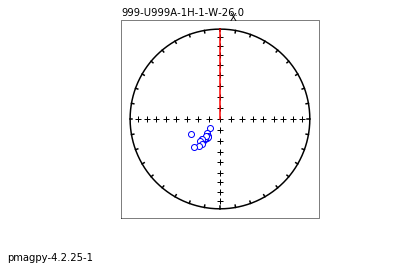

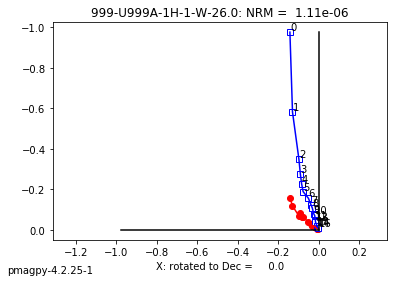

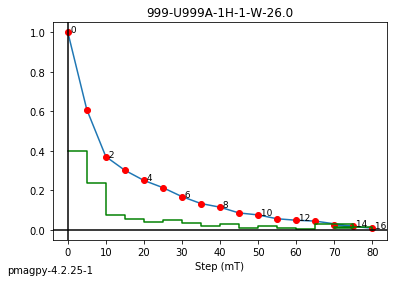

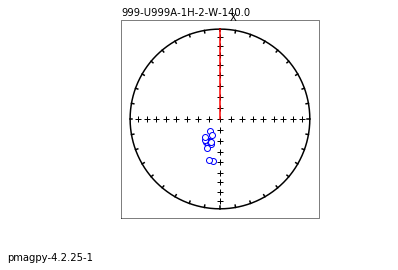

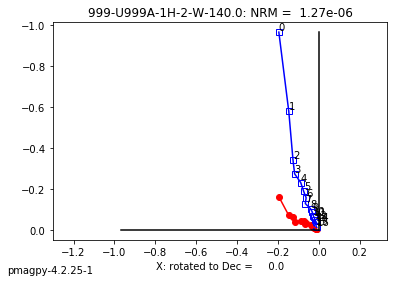

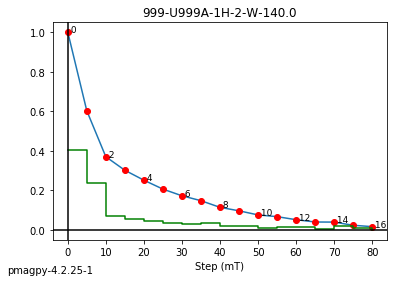

In [14]:
if dscr_file:
    ipmag.zeq_magic(meas_file=dscr_file,\
                spec_file='lims_specimens.txt',input_dir_path=magic_dir,n_plots="all",save_plots=False)

If you did a bunch of full demagnetizations, set the your maximum af field.  To save your plots, set save_plots to True.  To change the output format, change 'svg' to whatever you want ('pdf','eps','png').  

In [17]:
cnt=1
max_field=0 # set this to your peak field (in tesla) to execute this

if max_field:
    srm_dscr_df=pd.read_csv(magic_dir+'/'+dscr_file,sep='\t',header=1)
    srm_dmag=srm_dscr_df[srm_dscr_df.treat_ac_field>=max_field] # find all the demag specimens
    spc_list=srm_dmag.specimen.unique()

    for spc in spc_list:
        ipmag.zeq_magic(meas_file=dscr_file,specimen=spc,fignum=cnt,\
                spec_file='lims_specimens.txt',input_dir_path=magic_dir,save_plots=False,
                       fmt='svg')
        cnt+=3;


### Import the JR6 data.  
- download the JR6 data from LIMS and put it in the JR6_data folder in your working directory.
- edit the file name in the cell below to reflect the actual file name.  
- execute the two cells in order. 

In [15]:
jr6_file='spinner_17_5_2019.csv' # JR6 data file from LORE
if jr6_file:
    convert.iodp_jr6_lore(jr6_file,meas_file='jr6_measurements.txt',dir_path=magic_dir,\
                     input_dir_path=jr6_dir,spec_file='lims_specimens.txt',noave=False)
    if 'jr6_measurements.txt' not in meas_files:meas_files.append('jr6_measurements.txt')
    dscr_file='jr6_measurements.txt'

5  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/jr6_measurements.txt


In [16]:

# combine srm and jr6 data: set this to True
if True:
    ipmag.combine_magic(['srm_dscr_measurements.txt','jr6_measurements.txt'],
                        outfile='dscr_measurements.txt',dir_path=magic_dir)
    dscr_file='dscr_measurements.txt'
max_field=80 # set this to your peak field (in tesla) to execute this
if max_field:
    cnt=1
    dscr_df=pd.read_csv(magic_dir+'/dscr_measurements.txt',sep='\t',header=1)
    dmag_df=dscr_df[dscr_df.treat_ac_field>=max_field] # find all the demag specimens
    spc_list=dmag_df.specimen.unique()

    for spc in spc_list:
        ipmag.zeq_magic(meas_file='dscr_measurements.txt',specimen=spc,fignum=cnt,\
                spec_file='lims_specimens.txt',input_dir_path=magic_dir,save_plots=False)
        cnt+=3;


-I- writing measurements records to /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/dscr_measurements.txt
-I- 39 records written to measurements file


<a id='aniso'></a>

###  AMS data

Convert AMS data to MagIC

- Download KAPPABRIDGE expanded magnetic susceptibility data from the Lims Online Repository
- place the downloaded .csv file in the KLY4S_data in the HOLE directory.  
- change kly4s_file below to the correct file name

In [18]:
kly4s_file='ex-kappa_17_5_2019.csv'
if kly4s_file:
    convert.iodp_kly4s_lore(kly4s_file, meas_out='kly4s_measurements.txt', 
           spec_infile='lims_specimens.txt', spec_out='kly4s_specimens.txt',
           dir_path=magic_dir, input_dir_path=kly4s_dir,actual_volume=7)
    if 'kly4s_measurements.txt' not in meas_files:meas_files.append('kly4s_measurements.txt')
    if 'kly4s_specimens.txt' not in meas_files:meas_files.append('kly4s_specimens.txt')

4  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/kly4s_measurements.txt
4  records written to file  /Users/ltauxe/Desktop/iodp_magic/U999A/U999A_MagIC/kly4s_specimens.txt


To make a depth plot of your AMS data, download the Core Summary File from LORE, put it in your HOLE_MagIC directory and enter the name in the sum_file argument below. 
Then change the False to True in the cell below and run it.

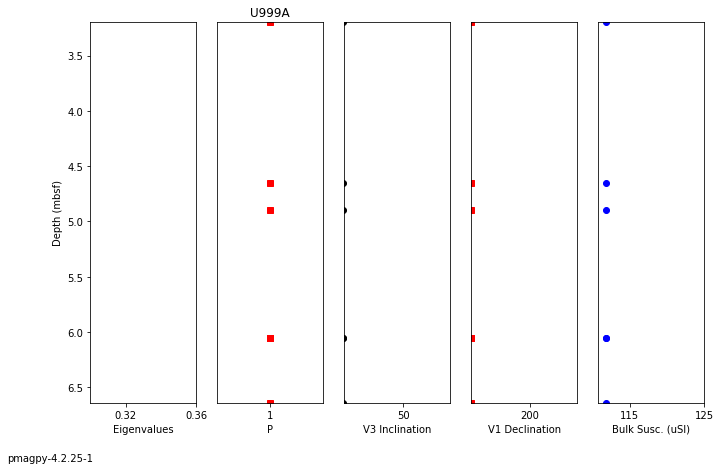

In [25]:
if True:
    ipmag.ani_depthplot(spec_file='kly4s_specimens.txt', dir_path=magic_dir, 
                    samp_file='lims_samples.txt',site_file='lims_sites.txt',
                   dmin=-1,dmax=-1,meas_file='kly4s_measurements.txt',
                   sum_file='Core Summary_17_5_2019.csv')
    plt.savefig('Figures/'+hole+'_anisotropy_xmastree.pdf')

This way makes equal area plots in core coordinates.... To run it, set the False to True.
To save the plots, sset save_plots to True.  for different options, try (help(ipmag.aniso_magic_nb)).

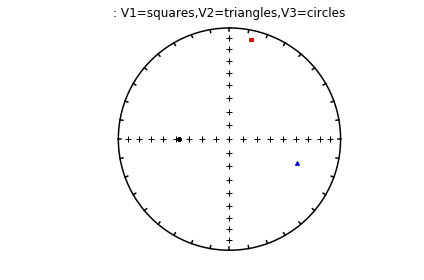

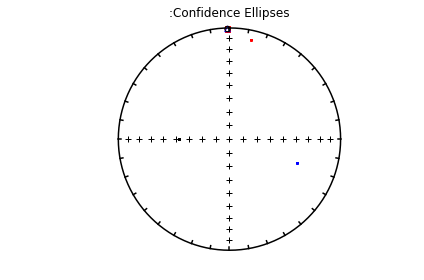

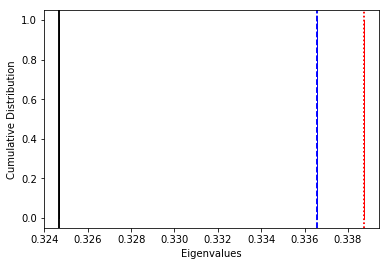

In [26]:
if True:
    ipmag.aniso_magic_nb(infile=magic_dir+'/kly4s_specimens.txt',\
                     verbose=False,save_plots=False,ihext=False,iboot=True,ivec=True)

<a id='plots'></a>

### Downhole Plots

- Fill in the section summary file in the preliminaries folder and run  the cells below

In [41]:
dscr_file="dscr_measurements.txt"
if dscr_file:
    srm_dscr_df=pd.read_csv(magic_dir+'/'+dscr_file,sep='\t',header=1)
    dscr_df=srm_dscr_df.copy(deep=True)
    dscr_df=dscr_df[srm_dscr_df['treat_ac_field']==demag_step]
    depth_data=pd.read_csv(magic_dir+'/lims_sites.txt',sep='\t',header=1)
    depth_data['specimen']=depth_data['site']
    depth_data=depth_data[['specimen','core_depth']]
    depth_data.sort_values(by='specimen')
    dscr_df=pd.merge(dscr_df,depth_data,on='specimen')
else:
    dscr_df=""


Plot saved in Figures/U999A_1.pdf


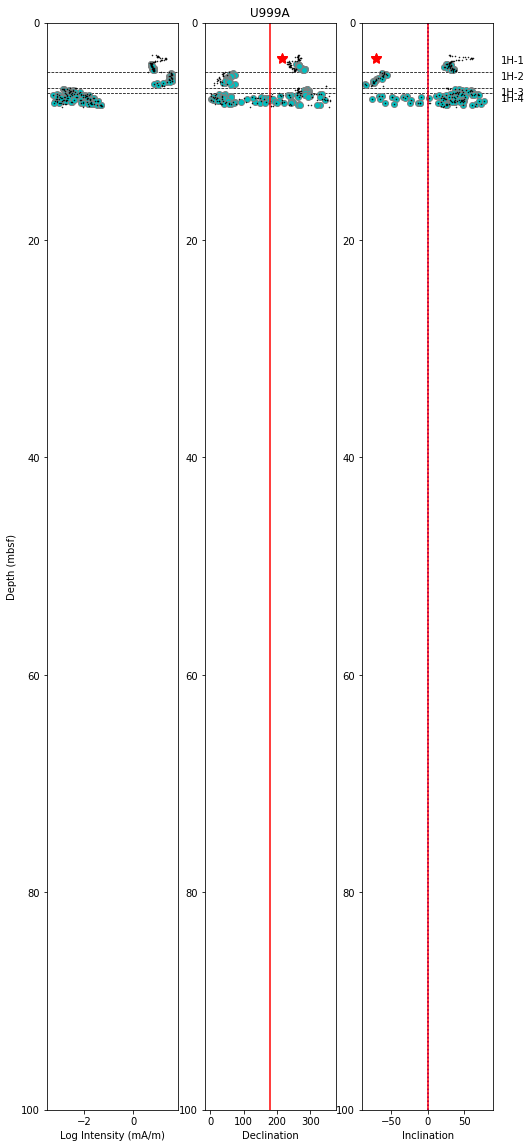

In [43]:
if section_summary_file:
    arch_demag_step=pd.read_csv(hole+'/'+hole+'_arch_demag_step.csv')
    adj_dec_df=pd.read_csv(hole+'/'+hole+'_dec_adjusted.csv')
#Let's get the section boundaries.  
# edit the file name for the Section Summary table downloaded from LIMS


    summary_df=pd.read_csv(summary_file)
    summary_df.dropna(subset=['Sect'],inplace=True)
    if type(summary_df.Sect)!='str':
        summary_df.Sect=summary_df.Sect.astype('int64')
        summary_df.Sect=summary_df.Sect.astype('str')
    summary_df=summary_df[summary_df['Sect'].str.contains('CC')==False]
    max_depth=arch_demag_step['core_depth'].max()

    summary_df=summary_df[summary_df['Top depth CSF-A (m)']<max_depth]
    sect_depths=summary_df['Top depth CSF-A (m)'].values
    summary_df['Core']=summary_df['Core'].astype('int')
    labels=summary_df['Core'].astype('str')+summary_df['Type']+'-'+summary_df['Sect'].astype('str')

    arch_demag_step=pd.read_csv(hole+'/'+hole+'_arch_demag_step.csv')
    interval=100 # how to divide up the plots
    depth_min,depth_max=0,interval
    fignum=1
    while depth_min<arch_demag_step.core_depth.max():
        iodp_funcs.make_plot(arch_demag_step,adj_dec_df,sect_depths,hole,\
                         gad_inc,depth_min,depth_max,labels,spec_df=dscr_df,fignum=fignum)
        depth_min+=interval
        depth_max+=interval
        fignum+=1

<a id='upload'></a>

###  Tidy up for MagC

Combine all the MagIC files for uploading to MagIC (http://earthref.org/MagIC).  


In [29]:
if False:
    ipmag.combine_magic(spec_files,outfile='specimens.txt',dir_path=magic_dir)
    ipmag.combine_magic(samp_files,outfile='samples.txt',dir_path=magic_dir)
    ipmag.combine_magic(site_files,outfile='sites.txt',dir_path=magic_dir)
    ipmag.combine_magic(meas_files,outfile='measurements.txt',dir_path=magic_dir)
    ipmag.upload_magic()